# Feature Importance Using Permutation in Python

Permutation importance is a technique used to measure the importance of features in a machine learning model. It provides insights into how much each feature contributes to the model's predictive performance. The basic idea is that we can take a feature, randomly shuffle or permute it, and measure the decrease in the model's predictive performance.

Often, permutation importance is used in feature selection, as it can help simplify model building, help improve interpretability, and reduce overfitting. Permutation importance can also be used in evaluating and comparing different models, as we can see which features contribute more to different models' performances. Furthermore, permutation importance doesn't assume any relationship between features and the target. It assesses each feature independently, which allows for the detection of both linear and non-linear relationships. 

Permutation importance has become an integral part of the toolkit for data scientists and machine learning practitioners seeking to gain insights into feature importance, enhance model interpretability, and make informed decisions based on their models. In this post we're going to look at a simple example of permutation importance and implement a permutation importance algorithm in Python. We'll also look at built-in permutation importance functions in some common Python libraries.

## So what is permutation?

We can think of permutation as re-arrangement. So, we take a feature and randomly shuffle the values in it. Here is a simple example of a feature (age) and a target (income).


| Age | Income |
| -- | -- |
| 20 | 30000 |
| 25 | 40000 |
| 30 | 50000 |
| 35 | 60000 |

Let's create this in Pandas:

In [1]:
# import dependencies
import pandas as pd
import numpy as np

age_income_df = pd.DataFrame({
    'Age': [20, 25, 30, 35],
    'Income': [30000, 40000, 50000, 60000]
})

age_income_df.head()

,Age,Income
0,20,30000
1,25,40000
2,30,50000
3,35,60000


Now, let's apply NumPy's `permutation` function to the `Age` column, which will randomly shuffle the values in the column:

In [3]:
# permute the Age column
age_income_df['Age_permuted'] = np.random.permutation(age_income_df['Age'].values)

age_income_df.head()

,Age,Income,Age_permuted
0,20,30000,35
1,25,40000,25
2,30,50000,20
3,35,60000,30


## An algorithm

So let's review an algorithm for calculating permutation importance.

1. First, train a machine learning model using a training dataset.
2. Evaluate that model's baseline performance on a validation dataset using an evaluation metric (e.g. accuracy, mean squared error).
3. Select the feature for which you want to calculate permutation importance.
4. Copy the validation dataset.
5. Randomly permute the values of the selected feature within the copied dataset while keeping the other features unchanged.
6. Use the trained model to make predictions on the permuted data and calculate the evaluation metric.
7. Compute the drop in performance by subtracting the permuted performance from the baseline performance.
8. Repeat steps 4 to 7 multiple times to obtain a collection of performance drops.
9. Calculate the permutation importance score for the feature by averaging the performance drops in step 8.
10. Repeat steps 3 to 9 for each other feature of interest.

Let's start to build out this algorithm in Python. First, we need a dataset, so let's use sklearn's `make_classification` to make a classification dataset for a binary classification task:

In [106]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# make a classification dataset (binary class) with 20 features, 2 of which are informative
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)

# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# split the training dataset into a training and dev/validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 

Now we're going to instantiate a logistic classifier and get a baseline accuracy score on our validation set.

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

base_model = LogisticRegression()
base_model.fit(X_train, y_train)

y_val_pred = base_model.predict(X_val)
base_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Baseline accuracy: {base_accuracy:.2f}')

Baseline accuracy: 0.76


Let's turn this into a function which accepts a scikit-learn model as an input, as well as other optional parameters:

In [108]:
def calc_permutation_importance(trained_model, X_val, y_val, n_permutations=100, features=None):
    base_accuracy = trained_model.score(X_val, y_val)
    print(f"Baseline accuracy: {base_accuracy:.3f}")
    # Select the feature for which you want to calculate permutation importance.
    if features:
        pass
    else: # all features
        features = X_val.shape[1]
        print(f"Calculating permutations on all {features} features...")
        feature_importances = np.zeros(features)
        for feature in range(features):
            performance_drop_list = np.zeros(n_permutations)
            for i in range(n_permutations):
    
                # Copy the validation dataset.
                X_val_copy = np.copy(X_val)

                # Randomly permute the values of the selected feature within the copied dataset
                X_val_copy[:,feature] = np.random.permutation(X_val[:,feature])

                # Use the trained model to make predictions on the permuted data and calculate the evaluation metric.
                permutation_pred = trained_model.predict(X_val_copy)
                permutation_accuracy = accuracy_score(permutation_pred, y_val)

                # Compute the drop in performance by subtracting the permuted performance from the baseline performance.
                performance_drop = base_accuracy - permutation_accuracy

                performance_drop_list[i] = performance_drop

            permutation_score = performance_drop_list.mean()
            print(f'Feature {feature} permutation score: {permutation_score}')
            feature_importances[feature] = permutation_score
    return feature_importances

In [109]:
imp = calc_permutation_importance(base_model, X_val, y_val)

Baseline accuracy: 0.761
Calculating permutations on all 20 features...
Feature 0 permutation score: 0.0023404255319148582
Feature 1 permutation score: -0.010319148936170251
Feature 2 permutation score: 0.07473404255319144
Feature 3 permutation score: -0.008510638297872372
Feature 4 permutation score: -0.016914893617021302
Feature 5 permutation score: 0.0865425531914893
Feature 6 permutation score: -0.011702127659574499
Feature 7 permutation score: -0.013244680851063863
Feature 8 permutation score: 0.0019680851063829463
Feature 9 permutation score: 0.0018617021276595325
Feature 10 permutation score: -0.0035106382978723726
Feature 11 permutation score: -0.006489361702127693
Feature 12 permutation score: -5.319148936170914e-05
Feature 13 permutation score: -0.012340425531914927
Feature 14 permutation score: -0.012925531914893656
Feature 15 permutation score: 0.02015957446808506
Feature 16 permutation score: -0.007925531914893653
Feature 17 permutation score: 0.05925531914893612
Feature 1

<BarContainer object of 20 artists>

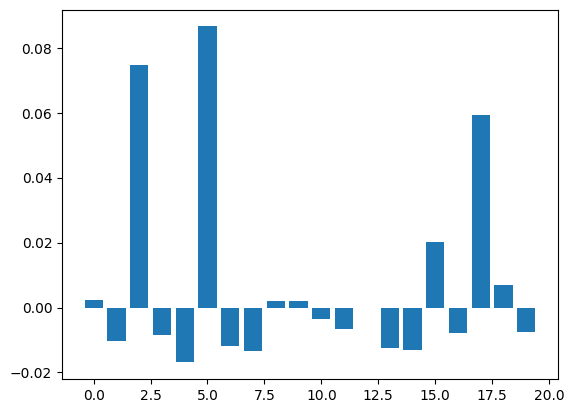

In [110]:
import matplotlib.pyplot as plt

plt.bar(range(20), imp)